In [1]:
# PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scheduler - OneCycleLR, CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR, PolynomialLR
import lightning as L
import wandb

import matplotlib.pyplot as plt
import scienceplots
import numpy as np
import polars as pl

In [2]:
L.seed_everything(42)

Seed set to 42


42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def load_data(file_path):
    df = pl.read_parquet(file_path)
    tensors = [torch.tensor(df[col].to_numpy().reshape(-1, 100), dtype=torch.float32) for col in df.columns]
    return tensors

In [5]:
train_tensors = load_data("../data/train.parquet")
val_tensors = load_data("../data/val.parquet")

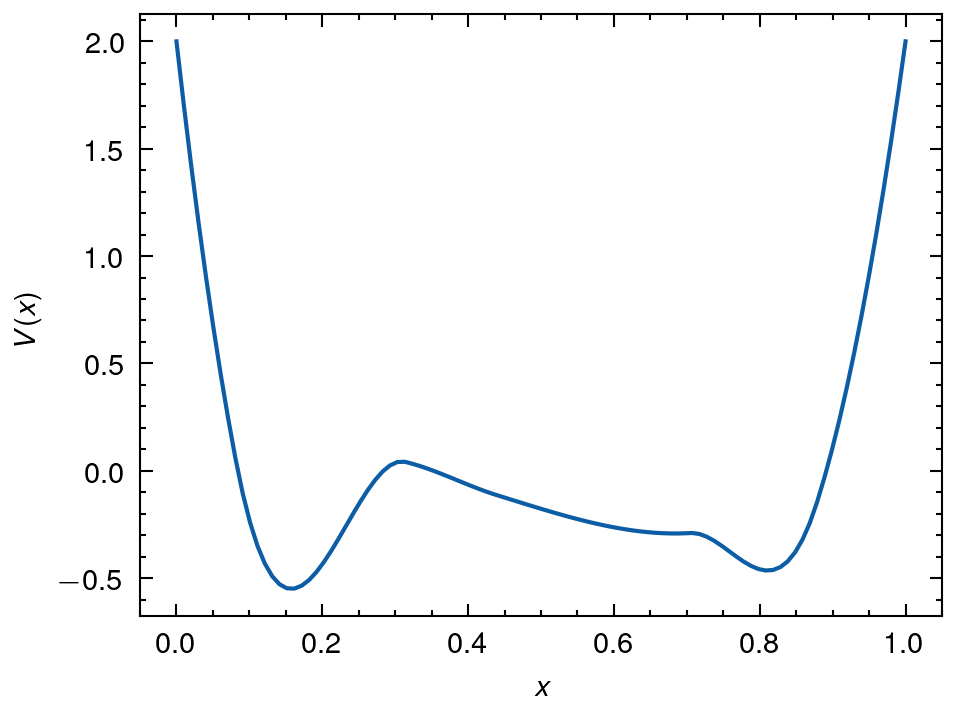

In [6]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(np.linspace(0, 1, 100), train_tensors[0][3])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential.png", dpi=600)
    plt.show()

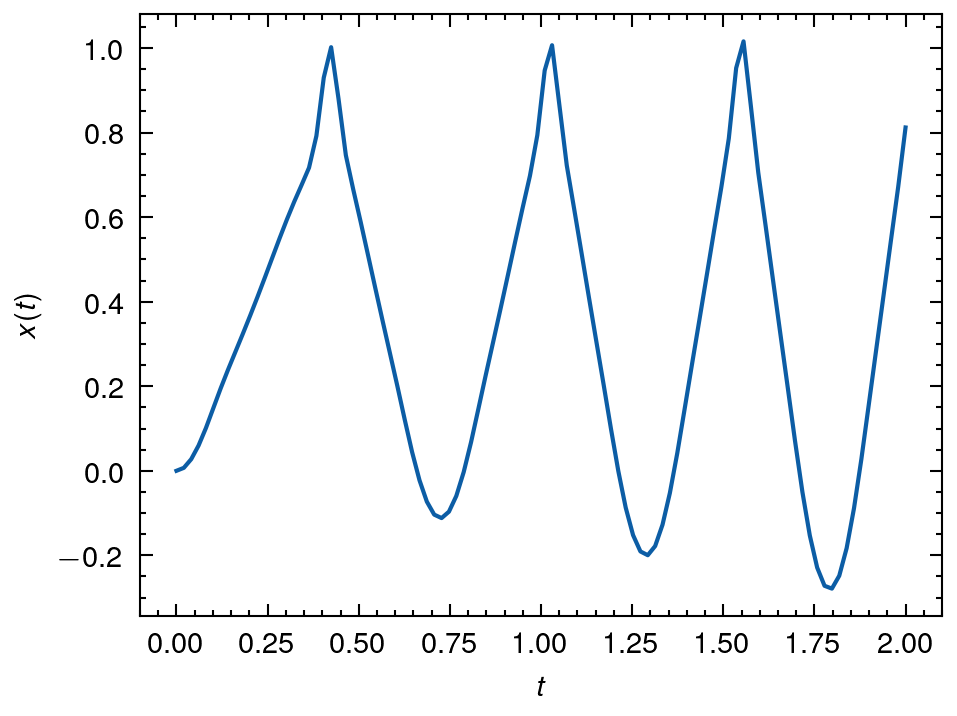

In [7]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(train_tensors[1][0], train_tensors[2][0])
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.tight_layout()
    plt.savefig("../figs/trajectory.png", dpi=600)
    plt.show()

In [8]:
ds_train = TensorDataset(*train_tensors)
ds_val = TensorDataset(*val_tensors)

In [9]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=10, num_layers=1, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)

    def forward(self, x):
        """
        - x: (B, W, 1)
        - h_n: (D * L, B, H) (D = 2 for bidirectional)
        - c_n: (D * L, B, H) (D = 2 for bidirectional)
        """
        _, (h_n, c_n) = self.rnn(x)
        return h_n, c_n
    
class Decoder(nn.Module):
    def __init__(self, hidden_size=10, num_layers=1, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, 1)

    def forward(self, x, h_c):
        """
        - x: (B, W, 1)
        - h_c: (D * L, B, H) (D = 2 for bidirectional)
        - o: (B, W, D * H) (D = 2 for bidirectional)
        - out: (B, W, 1)
        """
        o, _ = self.rnn(x, h_c)
        out = self.fc(o)
        return out

class VAONet(nn.Module):
    def __init__(self, hparams):
        super().__init__()

        hidden_size = hparams["hidden_size"]
        latent_size = hparams["latent_size"]
        num_layers = hparams["num_layers"]
        dropout = hparams["dropout"]
        kl_weight = hparams["kl_weight"]
        
        self.branch_net = Encoder(hidden_size, num_layers, dropout)
        self.trunk_net = Decoder(hidden_size, num_layers, dropout)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_var = nn.Linear(hidden_size, latent_size)
        self.fc_z = nn.Linear(latent_size, hidden_size)
        self.kl_weight = kl_weight
        self.reparametrize = True

    def forward(self, u, y):
        B, W1 = u.shape
        _, W2 = y.shape
        u = u.view(B, W1, 1)
        y = y.view(B, W2, 1)

        # Encoding
        (h0, c0) = self.branch_net(u)

        # Reparameterize (VAE)
        hp = h0.permute(1,0,2).contiguous()     # B, D * L, H
        mu = self.fc_mu(hp)                     # B, D * L, Z
        logvar = self.fc_var(hp)                # B, D * L, Z
        if self.reparametrize:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
        else:
            z = mu

        # Decoding
        hz = self.fc_z(z)                       # B, D * L, H
        hzp = hz.permute(1,0,2).contiguous()    # D * L, B, H
        h_c = (hzp, c0)
        o = self.trunk_net(y, h_c)              # B, W2, 1
        return o.squeeze(-1), mu, logvar

In [10]:
def train_epoch(model, optimizer, dataloader, device):
    model.train()
    epoch_loss = 0
    epoch_kl_loss = 0
    for u, y, Guy in dataloader:  
        optimizer.zero_grad()
        pred, mu, logvar = model(u.to(device), y.to(device))

        # Flatten
        mu_vec = mu.view((mu.shape[0], -1))             # B, D * L * Z
        logvar_vec = logvar.view((logvar.shape[0], -1)) # B, D * L * Z

        # KL Divergence (mean over latent dimensions)
        kl_loss = -0.5 * torch.mean(1 + logvar_vec - mu_vec.pow(2) - logvar_vec.exp(), dim=1)
        kl_loss = model.kl_weight * torch.mean(kl_loss)
        loss = F.mse_loss(pred, Guy.to(device)) + kl_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_kl_loss += kl_loss.item()
    epoch_loss /= len(dataloader)
    epoch_kl_loss /= len(dataloader)
    return epoch_loss, epoch_kl_loss

def evaluate(model, dataloader, device):
    model.eval()  
    eval_loss = 0
    eval_kl_loss = 0
    with torch.no_grad():
        for u, y, Guy in dataloader:
            pred, mu, logvar = model(u.to(device), y.to(device))
            
            # Flatten
            mu_vec = mu.view((mu.shape[0], -1))             # B, D * L * Z
            logvar_vec = logvar.view((logvar.shape[0], -1)) # B, D * L * Z

            # KL Divergence (mean over latent dimensions)
            kl_loss = -0.5 * torch.mean(1 + logvar_vec - mu_vec.pow(2) - logvar_vec.exp(), dim=1)
            kl_loss = model.kl_weight * torch.mean(kl_loss)
            loss = F.mse_loss(pred, Guy.to(device)) + kl_loss
            
            eval_loss += loss.item()
            eval_kl_loss += kl_loss.item()
    eval_loss /= len(dataloader)
    eval_kl_loss /= len(dataloader)
    return eval_loss, eval_kl_loss

In [11]:
hparams = {
    "hidden_size": 64,
    "num_layers": 3,
    "learning_rate": 1e-2,
    "batch_size": 2000,
    "epochs": 100,
    "dropout": 0.1,
    "latent_size": 16,
    "kl_weight": 1e-1
}

In [12]:
model = VAONet(hparams)
model.to(device)
dl_train = DataLoader(ds_train, batch_size=hparams["batch_size"], shuffle=True)
dl_val = DataLoader(ds_val, batch_size=hparams["batch_size"])
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])
scheduler = PolynomialLR(optimizer, total_iters=int(hparams["epochs"]), power=2.0)
# scheduler = OneCycleLR(optimizer, max_lr=hparams["learning_rate"], epochs=hparams["epochs"], steps_per_epoch=1)

run_name = f"vae_{hparams['hidden_size']}_{hparams['num_layers']}_{hparams['latent_size']}_more"
wandb.init(project="DeepONet-Hamilton-Bound", config=hparams, name=run_name)

for epoch in range(hparams["epochs"]):
    train_loss, train_kl_loss = train_epoch(model, optimizer, dl_train, device)
    val_loss, val_kl_loss = evaluate(model, dl_val, device)
    scheduler.step()
    wandb.log({
        "train_loss": train_loss,
        "train_kl_loss": train_kl_loss,
        "val_loss": val_loss,
        "val_kl_loss": val_kl_loss,
        "epoch": epoch+1, 
        "lr": scheduler.get_last_lr()[0]
    })

wandb.finish()

# Save
torch.save(model.state_dict(), f"../checkpoints/{run_name}.pth")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_kl_loss,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
lr,0.0
train_kl_loss,0.0
train_loss,0.00038
val_kl_loss,0.0


In [13]:
model.eval()
model.reparametrize = False

In [14]:
(u_test, y_test, Guy_test) = next(iter(dl_val))

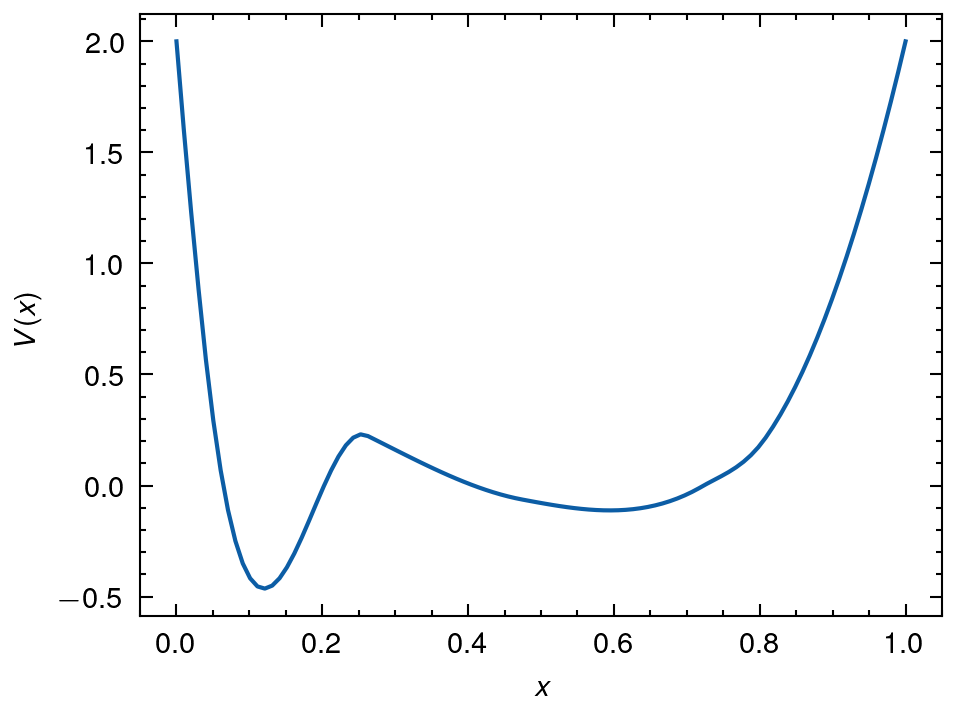

In [15]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(np.linspace(0, 1, 100), u_test[0].cpu().numpy())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_test.png", dpi=600)
    plt.show()

In [16]:
with torch.no_grad():
    Guy_hat, _, _ = model(u_test[0:1,:].to(device), y_test[0:1,:].to(device))

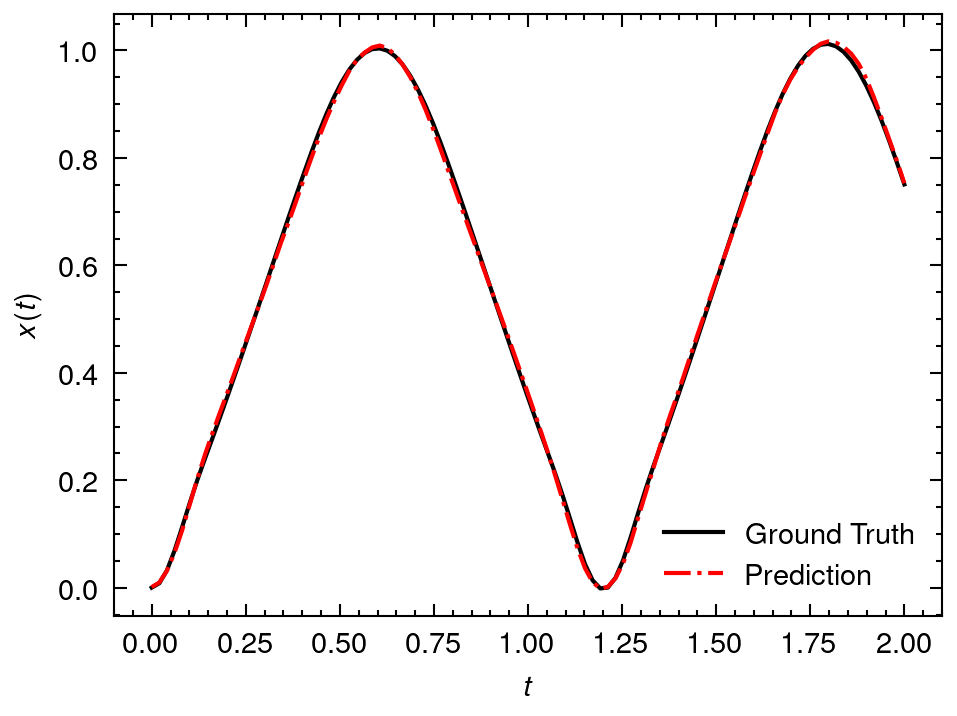

In [17]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y_test[0].cpu().numpy(), Guy_test[0].cpu().numpy(), 'k-', label="Ground Truth")
    plt.plot(y_test[0].cpu().numpy(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_test.png", dpi=600)
    plt.show()

## Custom Test

$$
\begin{aligned}
&V(x) = 8 (x - 0.5)^2,~ x(0) = 0,~ x'(0) = 0 \\
&x'' = -V'(x) = -16 (x - 0.5) \\
\Rightarrow ~ &x(t) = 0.5 - 0.5 \cos(4t)
\end{aligned}
$$

In [18]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = 8 * (x-0.5)**2
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = 0.5 - 0.5 * torch.cos(4 * y)

with torch.no_grad():
    Guy_hat, _, _ = model(u.to(device), y.to(device))

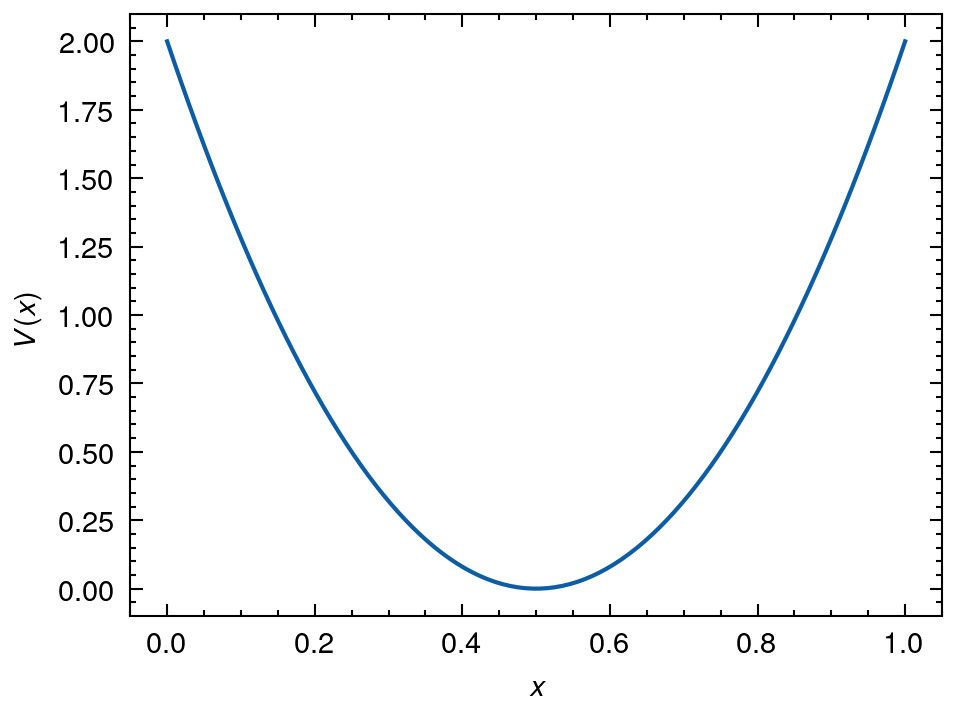

In [19]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x.cpu().numpy().flatten(), u.cpu().numpy().flatten())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred.png", dpi=600)
    plt.show()

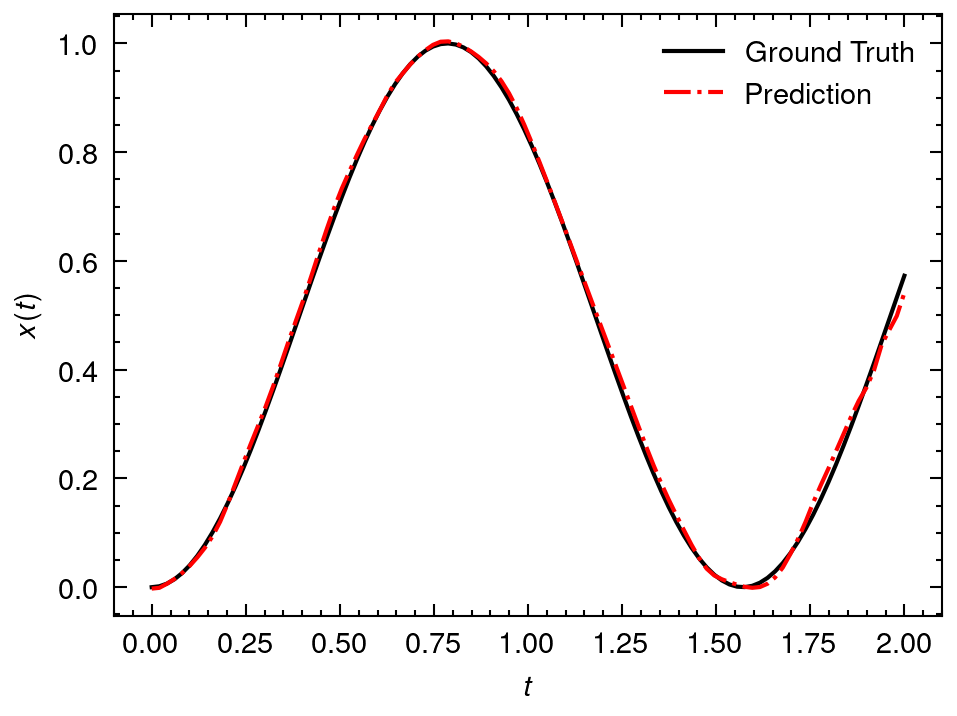

In [20]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y.cpu().numpy().flatten(), Guy.cpu().numpy().flatten(), 'k-', label="Ground Truth")
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred.png", dpi=600)
    plt.show()

## Custom Test 2

$$
\begin{aligned}
&V(x) = 4|x - 0.5|,~ x(0) = 0,~ x'(0) = 0 \\
&x'' = -V'(x) = \begin{cases} 4, & x < 0.5 \\ -4, & x > 0.5 \end{cases} \\
\Rightarrow ~ &x(t) = \begin{cases} 2t^2 & 0 < t < 0.5 \\ -2t^2 + 4t - 1& 0.5 \leq t < 1 \end{cases}
\end{aligned}
$$

In [21]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = 4 * torch.abs(x - 0.5)
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = torch.zeros_like(y)
Guy[y < 0.5] = 2 * y[y < 0.5] ** 2
ics = (y >= 0.5) & (y < 1.5)
Guy[ics] = -2 * y[ics]**2 + 4 * y[ics] - 1
ics = y >= 1.5
Guy[ics] = 2 * (2 - y[ics])**2

with torch.no_grad():
    Guy_hat, _, _ = model(u.to(device), y.to(device))

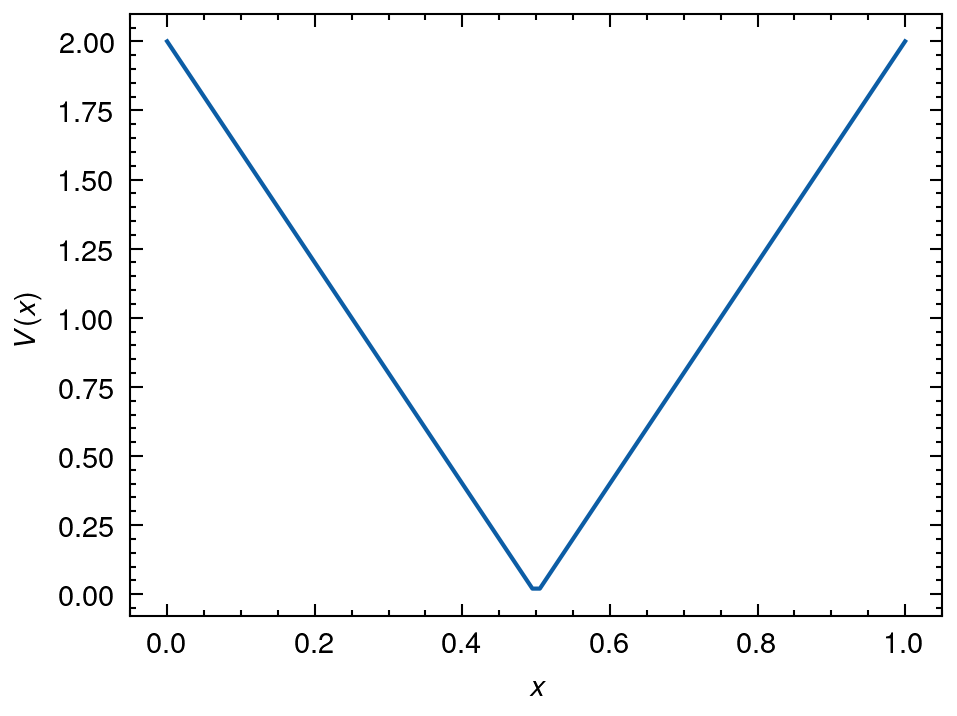

In [22]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x.cpu().numpy().flatten(), u.cpu().numpy().flatten())
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred2.png", dpi=600)
    plt.show()

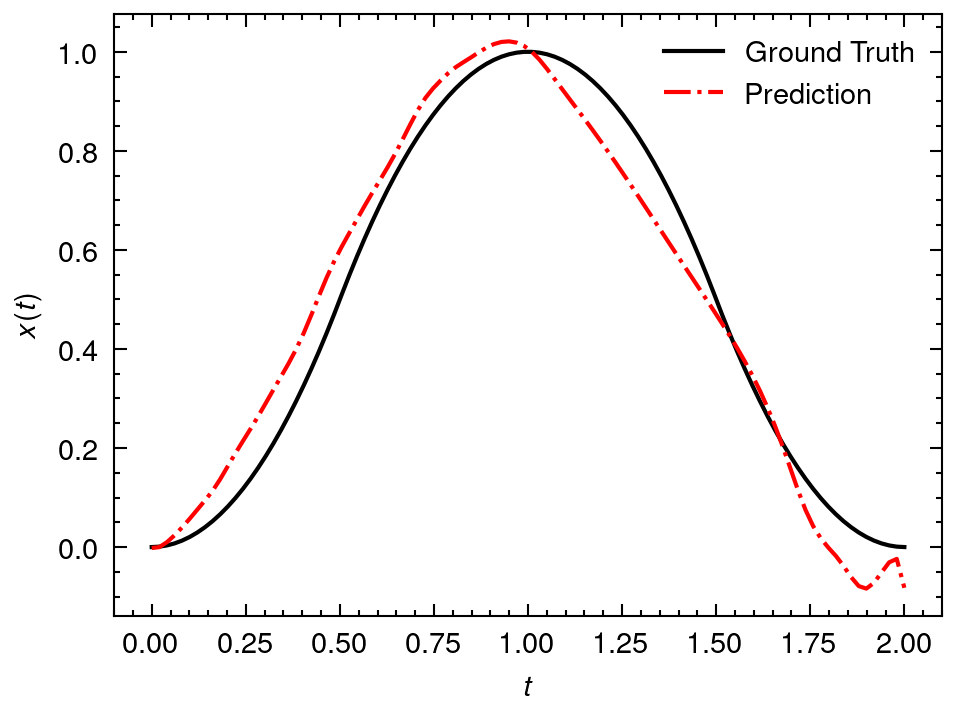

In [23]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(y.cpu().numpy().flatten(), Guy.cpu().numpy().flatten(), 'k-', label="Ground Truth")
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.', label="Prediction")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.legend()
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred2.png", dpi=600)
    plt.show()

## Custom Test 3

$$
\begin{aligned}
&V(x) = \frac{625}{8}\left(x - \frac{1}{5}\right)^2\left(x-\frac{4}{5}\right)^2, ~ x(0) = 0, ~ \dot{x}(0) = 0 \\
\Rightarrow ~ &
\begin{cases}
\dot{x} = p \\
\dot{p} = -V'(x) = -\dfrac{625}{2}x^3 + \dfrac{1875}{4}x^2 - \dfrac{825}{4}x + 25
\end{cases}
\end{aligned}
$$

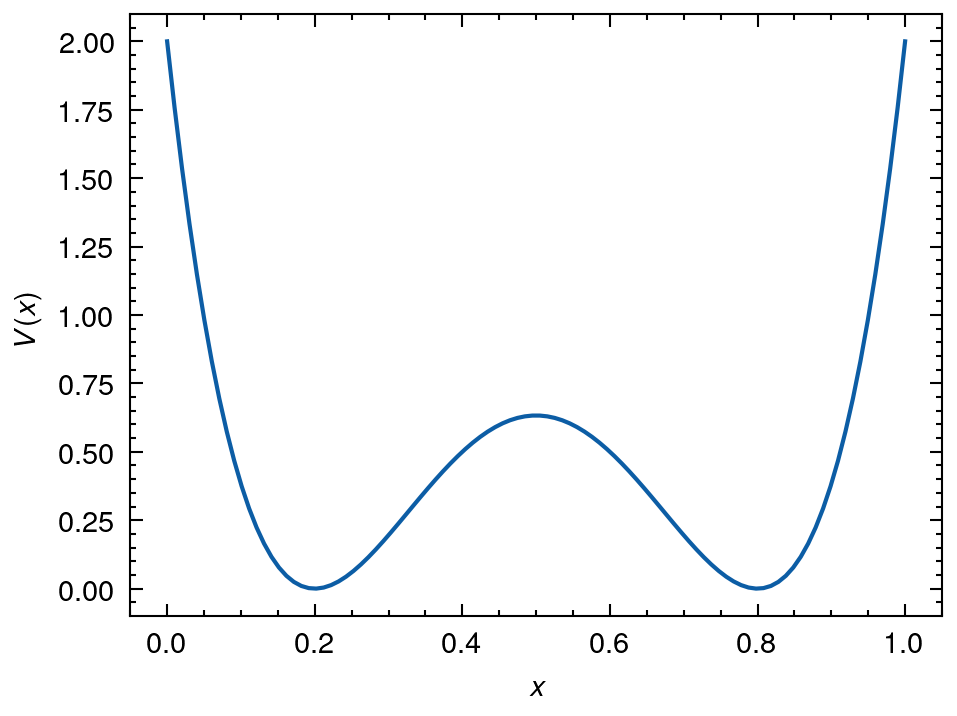

In [24]:
def V(x):
    return 625/8 * (x - 1/5)**2 * (x - 4/5)**2

x = np.linspace(0, 1, 100)

with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(x, V(x))
    plt.xlabel(r"$x$")
    plt.ylabel(r"$V(x)$")
    plt.tight_layout()
    plt.savefig("../figs/potential_pred3.png", dpi=600)
    plt.show()

In [25]:
from scipy.integrate import odeint

def dydt(y, t):
    x, p = y
    dxdt = p
    dpdt = -625/2 * x**3 + 1875/4 * x**2 - 825/4 * x + 25
    return [dxdt, dpdt]

y0 = [0, 0]  # 초기 조건: x(0) = 0, x'(0) = 0
t = np.linspace(0, 2, 100)  # 시간 범위 설정
sol = odeint(dydt, y0, t)

x_true = sol[:,0]
p_true = sol[:,1]

In [26]:
x = torch.linspace(0, 1, 100).view(1, -1)
u = V(x)
y = torch.linspace(0, 2, 100).view(1, -1)
Guy = torch.tensor(x_true).view(1, -1)

with torch.no_grad():
    Guy_hat, _, _ = model(u.to(device), y.to(device))

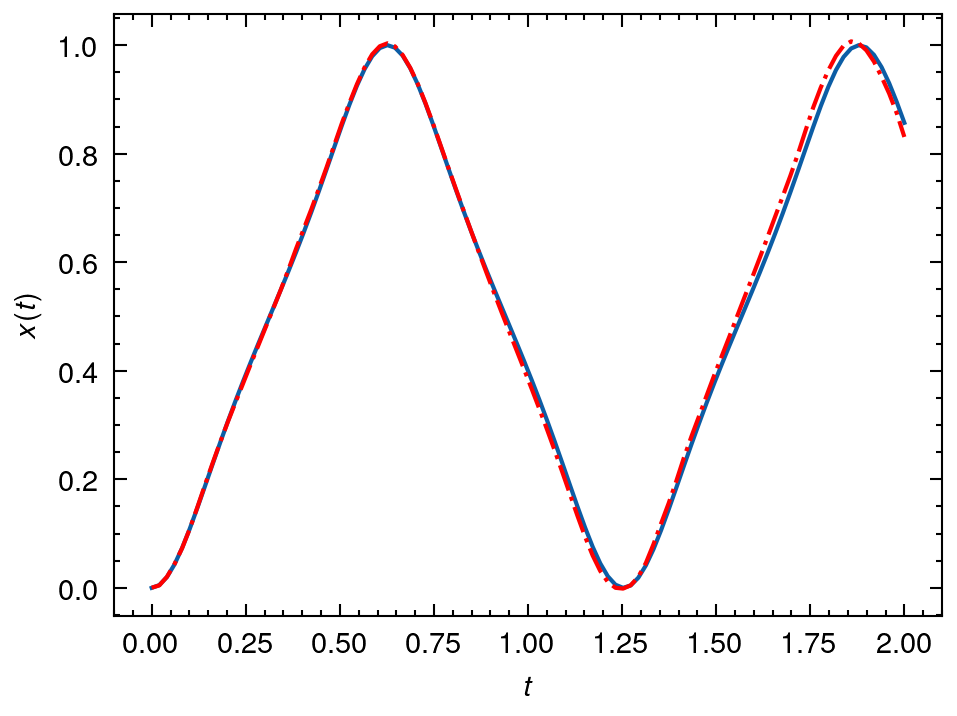

In [27]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=300)
    plt.plot(t, x_true)
    plt.plot(y.cpu().numpy().flatten(), Guy_hat.cpu().numpy().flatten(), 'r-.')
    plt.xlabel(r"$t$")
    plt.ylabel(r"$x(t)$")
    plt.tight_layout()
    plt.savefig("../figs/trajectory_pred3.png", dpi=600)
    plt.show()